# 工作流程
* 載入需要的套件
* 從COCO的驗證資料集中找一張範例照片，並且網上下載，顯示照片
* 進行物件偵測，做方框標記
* 列出偵測出來的類別代碼，以及方框座標
* 列出代碼對應的物件
* 顯示辨識出來的圖形
* 展示骨骼標記
* 展示全景分割

In [1]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 6.6MB 634kB/s 
     |████████████████████████████████| 2.2MB 11.2MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201104-cp36-none-any.whl size=44419 sha256=f5be5774efc652ba5068a3e2ea6e69c28ef95c028372d5f2ccecf08038d220af
  Stored in directory: /root/.cache/pip/wheels/ec/4d/40/4077356fe02ef345791713eabede5ed63afe7d613b016694d1
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [3]:
import detectron2
import cv2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from matplotlib import pyplot as plt

--2020-11-09 05:42:47--  https://pic.pimg.tw/gsctw/1569307348-4222911024.jpg
Resolving pic.pimg.tw (pic.pimg.tw)... 23.33.180.80
Connecting to pic.pimg.tw (pic.pimg.tw)|23.33.180.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 282154 (276K) [image/jpeg]
Saving to: ‘input.jpg’

input.jpg           100%[===================>] 275.54K   940KB/s    in 0.3s    

2020-11-09 05:42:48 (940 KB/s) - ‘input.jpg’ saved [282154/282154]



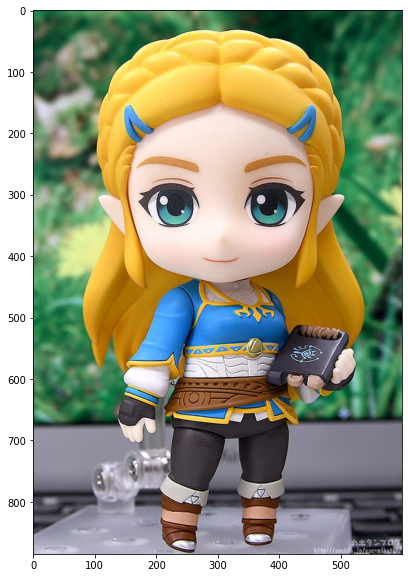

In [4]:
!wget https://pic.pimg.tw/gsctw/1569307348-4222911024.jpg -O input.jpg
im = cv2.imread("./input.jpg")
plt.figure(figsize=(20,10))
plt.imshow(im[:,:,::-1])

# 程式流程
* 宣告設定檔物件
* 取得設定檔，指定需要的模型種類
* 設定辨識值的門檻
* 下載模型
* 宣告偵測器，並且進行偵測
* 展示類別代碼及標記值
* 利用內建Visualizer將偵測出的圖形顯示出來

In [5]:
# Inference with a object detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

# If your detectron2's version is not the most updated, please use direct link as followed, to get the link , please visit 
# https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md

# cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"

predictor = DefaultPredictor(cfg)
outputs = predictor(im)


model_final_280758.pkl: 167MB [00:07, 21.1MB/s]                           
/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


In [6]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([46,  0], device='cuda:0')
Boxes(tensor([[100.7897,  29.5382, 529.6243, 577.6227],
        [ 78.9596,   0.0000, 531.3151, 885.0000]], device='cuda:0'))


In [7]:
all_things = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
preds = [all_things[x] for x in outputs["instances"].pred_classes]
preds

['banana', 'person']

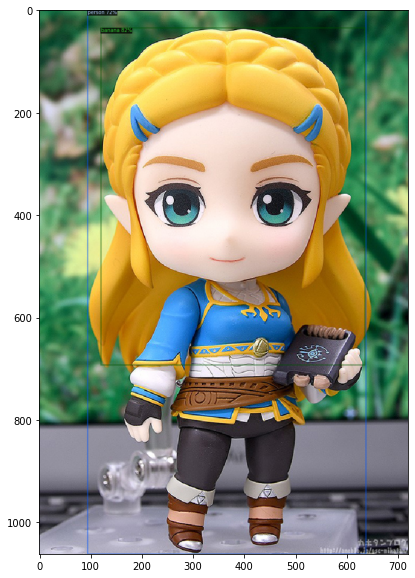

In [8]:
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())

model_final_f10217.pkl: 178MB [00:08, 21.5MB/s]                           


['banana', 'person']


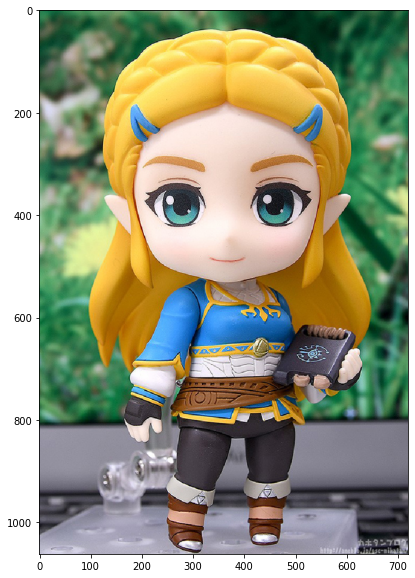

In [9]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
#cfg.MODEL.WEIGHTS = './model_final_f10217.pkl'
predictor = DefaultPredictor(cfg)
all_things = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
preds = [all_things[x] for x in outputs["instances"].pred_classes]
print(preds)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())

model_final_a6e10b.pkl: 237MB [00:10, 22.9MB/s]                           


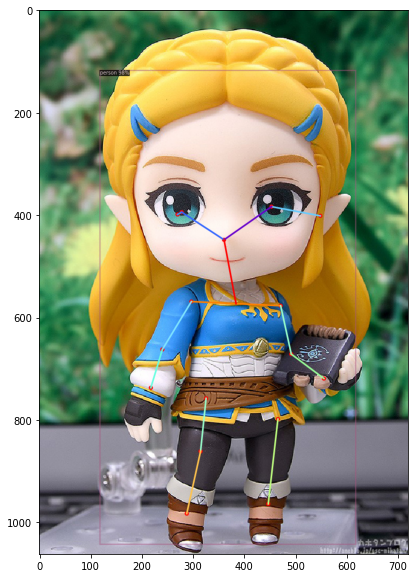

In [10]:
# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())

model_final_cafdb1.pkl: 261MB [00:11, 23.1MB/s]                           


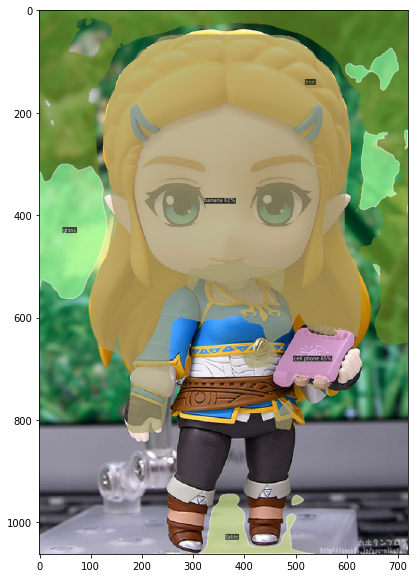

In [11]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())